In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import subprocess
import os
from scipy.stats import mannwhitneyu

#### Число пиков, когда мы не делаем slop:

In [2]:
bed_files = glob.glob("./sns_chip/sorted/*.bed")

In [3]:
bed_files

['./sns_chip/sorted/ChIP-seq MCM7_hg38_K562 ENCLB193OOL.bed',
 './sns_chip/sorted/Chip-seq ORC1_hg18_GradientHela_enrichRegions.bed',
 './sns_chip/sorted/Chip-seq MCM7_hg19_HeLa_exp1.bed',
 './sns_chip/sorted/SNS-seq_hg38_HMEC (mammary epithelial).bed',
 './sns_chip/sorted/ChIP-seq MCM7_hg38_K562 ENCLB235XDX.bed',
 './sns_chip/sorted/SNS-seq_hg38_CD34(+) hematopoetic.bed',
 './sns_chip/sorted/SNS-seq_hg19_MCF7.bed',
 './sns_chip/sorted/SNS-seq_hg19_K562_GSE46189.bed',
 './sns_chip/sorted/SNS-seq_hg19_K562_GSM716435.bed',
 './sns_chip/sorted/SNS-seq_hg38_hESC.bed']

In [99]:
!mkdir "./sns_chip/sorted/original_peaks"

In [104]:
with open("./sns_chip/sorted/original_peaks/multiintersected.bed", 'w') as outfile:
    proc = subprocess.Popen(['multiIntersectBed', '-i'] + all_bed, stdout=outfile)
    proc.wait()

!awk '{ if ($4 > 1) {print} }' ./sns_chip/sorted/original_peaks/multiintersected.bed > ./sns_chip/sorted/original_peaks/filtered.bed
!bedtools merge -i ./sns_chip/sorted/original_peaks/filtered.bed > ./sns_chip/sorted/original_peaks/merged.bed
!wc -l ./sns_chip/sorted/original_peaks/merged.bed

302649 ./sns_chip/sorted/original_peaks/merged.bed


#### Тестим slop, насколько нам нужно расширить пики
SNS + Chip

In [14]:
bed_files = glob.glob("./sns_chip/sorted/*.bed")
chrom_sizes_file = "./sns_chip/sorted/hg38.chrom.sizes"

number_of_peaks = [302649]  # 302649 - number of standart peaks, not sloped

os.mkdir('./sns_chip/sorted/intersected/')
os.mkdir('./sns_chip/sorted/intersected/filtered')
os.mkdir('./sns_chip/sorted/intersected/filtered/merged')

# slop peaks

for slop in range(100, 1000, 100): 
    sloped_files = []
    
    output_file_directory = "./sns_chip/sorted/sloped_" + str(slop) + "/"
    os.mkdir(output_file_directory)
    
    for bed_file in bed_files:
        
        output_file_name = bed_file.split('/')[-1]
        output_file_path = output_file_directory + output_file_name
        
        with open(output_file_path, "w") as outfile:
            my_cmd = ['bedtools', 'slop', '-i', bed_file, '-g', chrom_sizes_file, '-b', str(slop)]
            subprocess.run(my_cmd, stdout=outfile)
            
        sloped_files.append(output_file_path)
        
    # intersect sloped peaks    
            
    sloped_intersect_output_path = "./sns_chip/sorted/intersected/sloped_" + str(slop) + ".bed"
    with open(sloped_intersect_output_path, 'w') as outfile:
        subprocess.run(['multiIntersectBed', '-i'] + sloped_files, stdout=outfile)
    
# filter peaks regions where there are almost 2 files in intersection area
    
intersected_files = glob.glob("./sns_chip/sorted/intersected/*.bed")

for file in intersected_files:
    
    filtered_file_name = file.split('/')[-1]
    filtered_file_path = "./sns_chip/sorted/intersected/filtered/" + filtered_file_name
    
    with open(filtered_file_path, "w") as outfile:
        subprocess.run(['awk', '{ if ($4 > 1) {print} }', file], stdout=outfile)

# merge filtered peaks
        
filtered_files = glob.glob("./sns_chip/sorted/intersected/filtered/*.bed")


for file in sorted(filtered_files):
    
    merged_file_name = file.split('/')[-1]
    merged_file_path = "./sns_chip/sorted/intersected/filtered/merged/" + merged_file_name
    
    with open(merged_file_path, "w") as outfile:
        subprocess.run(['bedtools', 'merge', '-i', file], stdout=outfile)
    
    # count number of merged peaks
    
    wc = subprocess.Popen(['wc', '-l', merged_file_path], stdout=subprocess.PIPE)
    output = subprocess.check_output(('awk', '{ print $1 }'), stdin=wc.stdout)
    wc.wait()
    number_of_peaks.append(int(output[:-1]))

In [28]:
number_of_peaks

[302649,
 329790,
 340484,
 343858,
 339466,
 332647,
 325357,
 317558,
 309323,
 300779]

In [29]:
slop_range = list(range(100, 1000, 100))
slop_range.insert(0, 0)
slop_range

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900]

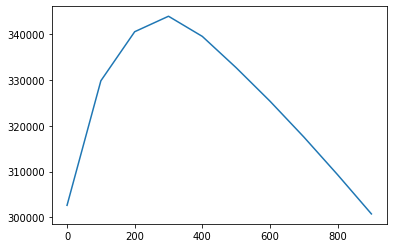

In [30]:
plt.plot(slop_range, number_of_peaks) # slop from 100 to 900

С условием "пик есть хотя бы в двух файлах" отсечка получилась 300

** Если делать промежуточный merge после slop, то разницы нет **

In [108]:
bed_files = glob.glob("./sns_chip/sorted/*.bed")
chrom_sizes_file = "./sns_chip/sorted/hg38.chrom.sizes"

number_of_peaks = [302649]  # 302649 - number of standart peaks, not sloped

os.mkdir('./sns_chip/sorted/intersected/')
os.mkdir('./sns_chip/sorted/intersected/filtered')
os.mkdir('./sns_chip/sorted/intersected/filtered/merged')

# slop peaks

for slop in range(100, 1000, 100): 
    sloped_files = []
    
    output_file_directory = "./sns_chip/sorted/sloped_" + str(slop) + "/"
    os.mkdir(output_file_directory)
    
    for bed_file in bed_files:
        
        output_file_name = bed_file.split('/')[-1]
        output_file_path = output_file_directory + output_file_name
        
        with open(output_file_path, "w") as outfile:
            slop_cmd = ['bedtools', 'slop', '-i', bed_file, '-g', chrom_sizes_file, '-b', str(slop)]
            slop_peaks = subprocess.Popen(slop_cmd, stdout=subprocess.PIPE)
            
            ##### intermediate merge peaks #####

            merge_sloped_peaks = subprocess.Popen(('bedtools', 'merge'), stdin=slop_peaks.stdout, stdout=outfile)
            slop_peaks.wait()
            merge_sloped_peaks.wait() 
            
        sloped_files.append(output_file_path)
        
        
    # intersect sloped peaks    
            
    sloped_intersect_output_path = "./sns_chip/sorted/intersected/sloped_" + str(slop) + ".bed"
    with open(sloped_intersect_output_path, 'w') as outfile:
        subprocess.run(['multiIntersectBed', '-i'] + sloped_files, stdout=outfile)
    
# filter peaks regions where there are almost 2 files in intersection area
    
intersected_files = glob.glob("./sns_chip/sorted/intersected/*.bed")

for file in intersected_files:
    
    filtered_file_name = file.split('/')[-1]
    filtered_file_path = "./sns_chip/sorted/intersected/filtered/" + filtered_file_name
    
    with open(filtered_file_path, "w") as outfile:
        subprocess.run(['awk', '{ if ($4 > 1) {print} }', file], stdout=outfile)

# merge filtered peaks
        
filtered_files = glob.glob("./sns_chip/sorted/intersected/filtered/*.bed")


for file in sorted(filtered_files):
    
    merged_file_name = file.split('/')[-1]
    merged_file_path = "./sns_chip/sorted/intersected/filtered/merged/" + merged_file_name
    
    with open(merged_file_path, "w") as outfile:
        subprocess.run(['bedtools', 'merge', '-i', file], stdout=outfile)
    
    # count number of merged peaks
    
    wc = subprocess.Popen(['wc', '-l', merged_file_path], stdout=subprocess.PIPE)
    output = subprocess.check_output(('awk', '{ print $1 }'), stdin=wc.stdout)
    wc.wait()
    number_of_peaks.append(int(output[:-1]))

In [110]:
number_of_peaks  # результат такой же, как раньше

[302649,
 329790,
 340484,
 343858,
 339466,
 332647,
 325357,
 317558,
 309323,
 300779]

### Более строгая отсечка - пики, которые есть хотя бы в половине файлов

In [6]:
len(bed_files) // 2  # половина файлов

5

In [8]:
!mkdir "./sns_chip/sorted/original_peaks_half"

In [9]:
with open("./sns_chip/sorted/original_peaks_half/multiintersected.bed", 'w') as outfile:
    proc = subprocess.Popen(['multiIntersectBed', '-i'] + all_bed, stdout=outfile)
    proc.wait()

!awk '{ if ($4 >= 5) {print} }' ./sns_chip/sorted/original_peaks_half/multiintersected.bed > ./sns_chip/sorted/original_peaks_half/filtered.bed
!bedtools merge -i ./sns_chip/sorted/original_peaks_half/filtered.bed > ./sns_chip/sorted/original_peaks_half/merged.bed
!wc -l ./sns_chip/sorted/original_peaks_half/merged.bed

11355 ./sns_chip/sorted/original_peaks_half/merged.bed


In [39]:
bed_files = glob.glob("./sns_chip/sorted/*.bed")
chrom_sizes_file = "./sns_chip/sorted/hg38.chrom.sizes"

number_of_peaks = [11355]  # 11355 - number of standart peaks, not sloped

os.mkdir('./sns_chip/sorted/intersected/')
os.mkdir('./sns_chip/sorted/intersected/filtered')
os.mkdir('./sns_chip/sorted/intersected/filtered/merged')

# slop peaks

for slop in range(1000, 5000, 500): 
    sloped_files = []
    
    output_file_directory = "./sns_chip/sorted/sloped_" + str(slop) + "/"
    os.mkdir(output_file_directory)
    
    for bed_file in bed_files:
        
        output_file_name = bed_file.split('/')[-1]
        output_file_path = output_file_directory + output_file_name
        
        with open(output_file_path, "w") as outfile:
            my_cmd = ['bedtools', 'slop', '-i', bed_file, '-g', chrom_sizes_file, '-b', str(slop)]
            subprocess.run(my_cmd, stdout=outfile)
            
        sloped_files.append(output_file_path)
        
    # intersect sloped peaks    
            
    sloped_intersect_output_path = "./sns_chip/sorted/intersected/sloped_" + str(slop) + ".bed"
    with open(sloped_intersect_output_path, 'w') as outfile:
        subprocess.run(['multiIntersectBed', '-i'] + sloped_files, stdout=outfile)
    
# filter peaks regions where there are almost half of the files (5) in intersection area
    
intersected_files = glob.glob("./sns_chip/sorted/intersected/*.bed")

for file in intersected_files:
    
    filtered_file_name = file.split('/')[-1]
    filtered_file_path = "./sns_chip/sorted/intersected/filtered/" + filtered_file_name
    
    with open(filtered_file_path, "w") as outfile:
        subprocess.run(['awk', '{ if ($4 >= 5) {print} }', file], stdout=outfile)

# merge filtered peaks
        
filtered_files = glob.glob("./sns_chip/sorted/intersected/filtered/*.bed")


for file in sorted(filtered_files):
    
    merged_file_name = file.split('/')[-1]
    merged_file_path = "./sns_chip/sorted/intersected/filtered/merged/" + merged_file_name
    
    with open(merged_file_path, "w") as outfile:
        subprocess.run(['bedtools', 'merge', '-i', file], stdout=outfile)
    
    # count number of merged peaks
    
    wc = subprocess.Popen(['wc', '-l', merged_file_path], stdout=subprocess.PIPE)
    output = subprocess.check_output(('awk', '{ print $1 }'), stdin=wc.stdout)
    wc.wait()
    number_of_peaks.append(int(output[:-1]))

In [19]:
number_of_peaks

[11355, 38826, 44979, 48866, 50432, 50900, 50529, 49950, 48935, 47547]

In [20]:
slop_range = list(range(1000, 5500, 500))
slop_range.insert(0, 0)
slop_range

[0, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

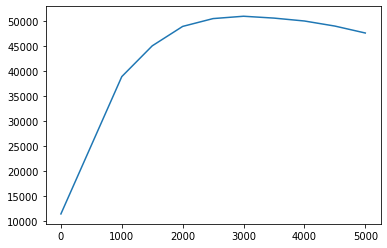

In [21]:
plt.plot(slop_range, number_of_peaks) # slop from 1000 to 5000

С условием "пик есть хотя бы в половине файлов" отсечка 3000

## Метилирование

### С расслабленной отсечкой (пик хотя бы в двух файлах)

In [16]:
!mv ./sns_chip/sorted/intersected/filtered/merged/sloped_300.bed ./concensus_methylation/

In [20]:
# среднее метилирование в пиках у старых доноров (без аутлаеров)
!bedtools map -a ./concensus_methylation/sloped_300.bed -b ./concensus_methylation/filtered_cytosines_freq_sorted.bed -c 4,5,6,7,8,9,10,12,13,14,15,16,17,18,20,21,22,23 -o mean > ./concensus_methylation/old_mean_methyl_300.bed

 ***** WARNING: Non numeric value NA in 20.
 ***** WARNING: Non numeric value NA in 5.
 ***** WARNING: Non numeric value NA in 16.
 ***** WARNING: Non numeric value NA in 21.
 ***** WARNING: Non numeric value NA in 9.
 ***** WARNING: Non numeric value NA in 5.
 ***** WARNING: Non numeric value NA in 7.
 ***** WARNING: Non numeric value NA in 17.
 ***** WARNING: Non numeric value NA in 8.
 ***** WARNING: Non numeric value NA in 5.
 ***** WARNING: Non numeric value NA in 5.
 ***** WARNING: Non numeric value NA in 18.
 ***** WARNING: Non numeric value NA in 5.
 ***** WARNING: Non numeric value NA in 23.
 ***** WARNING: Non numeric value NA in 17.
 ***** WARNING: Non numeric value NA in 17.
 ***** WARNING: Non numeric value NA in 22.
 ***** WARNING: Non numeric value NA in 14.
 ***** WARNING: Non numeric value NA in 6.
 ***** WARNING: Non numeric value NA in 23.
 ***** WARNING: Non numeric value NA in 14.
 ***** WARNING: Non numeric value NA in 7.
 ***** WARNING: Non numeric value NA in 21

In [22]:
# среднее метилирование в пиках у молодых доноров (без аутлаеров)
!bedtools map -a ./concensus_methylation/sloped_300.bed -b ./concensus_methylation/filtered_cytosines_freq_sorted.bed -c 24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42 -o mean > ./concensus_methylation/young_mean_methyl_300.bed

 ***** WARNING: Non numeric value NA in 31.
 ***** WARNING: Non numeric value NA in 25.
 ***** WARNING: Non numeric value NA in 36.
 ***** WARNING: Non numeric value NA in 25.
 ***** WARNING: Non numeric value NA in 27.
 ***** WARNING: Non numeric value NA in 29.
 ***** WARNING: Non numeric value NA in 39.
 ***** WARNING: Non numeric value NA in 37.
 ***** WARNING: Non numeric value NA in 24.
 ***** WARNING: Non numeric value NA in 32.
 ***** WARNING: Non numeric value NA in 25.
 ***** WARNING: Non numeric value NA in 32.
 ***** WARNING: Non numeric value NA in 27.
 ***** WARNING: Non numeric value NA in 41.
 ***** WARNING: Non numeric value NA in 39.
 ***** WARNING: Non numeric value NA in 24.
 ***** WARNING: Non numeric value NA in 41.
 ***** WARNING: Non numeric value NA in 42.
 ***** WARNING: Non numeric value NA in 35.
 ***** WARNING: Non numeric value NA in 25.
 ***** WARNING: Non numeric value NA in 34.
 ***** WARNING: Non numeric value NA in 34.
 ***** WARNING: Non numeric valu

In [89]:
# прочитываем старых
old = pd.read_table("./concensus_methylation/old_mean_methyl_300.bed", sep="\t", header=None)

In [24]:
old.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,chr1,15732,16499,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
1,chr1,17100,17579,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
2,chr1,51702,52638,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
3,chr1,73127,73967,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
4,chr1,136292,138375,70.50125,.,71.7525,70.946,74.479125,70.48375,68.58725,...,71.32675,70.384875,.,.,71.429875,66.909625,.,72.682875,69.921875,70.224375


In [90]:
# оставляем только колонки с метилированием, координаты убираем, т.к. нас уже не интересуют конкретные пики
old_meth_only = old.iloc[:,3:]

In [91]:
# конвертируем значения метилирования во float, где точки - присваиваем NaN
old_meth_only = old_meth_only.apply(pd.to_numeric, errors='coerce') 

In [92]:
# считаем среднее по каждой колонке с донором (т.е. усредняем по всем пикам), присваиваем, что они old
old_mean = pd.DataFrame(old_meth_only.mean().to_dict(),index=[old_meth_only.index.values[-1]]).assign(Age='old')

In [28]:
old_mean.head()

,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,Age
343857,72.517244,74.949485,73.354184,73.021439,72.69579,71.735019,72.93419,72.884363,73.038953,73.054126,72.913096,72.968534,72.923351,72.495649,72.407064,74.28363,72.501297,72.916473,old


In [134]:
# прочитываем молодых
young = pd.read_table("./concensus_methylation/young_mean_methyl_300.bed", sep="\t", header=None)

In [139]:
young.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,chr1,15732,16499,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
1,chr1,17100,17579,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2,chr1,51702,52638,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
3,chr1,73127,73967,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
4,chr1,136292,138375,72.73575,72.19725,71.093,64.58325,70.490625,71.206875,71.464875,.,69.858,71.590875,67.85725,69.974875,72.278,67.36975,72.855,72.6345,72.641,69.99475,72.42975


In [94]:
# оставляем только колонки с метилированием, координаты убираем, т.к. нас уже не интересуют конкретные пики
young_meth_only = young.iloc[:,3:]

In [95]:
# конвертируем значения метилирования во float, где точки - присваиваем NaN
young_meth_only = young_meth_only.apply(pd.to_numeric, errors='coerce') 

In [96]:
# считаем среднее по каждой колонке с донором (т.е. усредняем по всем пикам), присваиваем, что они old
young_mean = pd.DataFrame(young_meth_only.mean().to_dict(),index=[young_meth_only.index.values[-1]]).assign(Age='young')

In [34]:
young_mean.head()

,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,Age
343857,72.56407,72.955754,72.474738,75.538739,72.87993,73.479398,72.732917,72.854817,73.210542,72.684895,73.154184,72.455885,71.828566,73.09385,72.733648,72.915649,72.979001,73.08573,72.375471,young


In [97]:
old_young = pd.concat([old_mean, young_mean])

In [98]:
# преобразуем DataFrame в формат, в котором столбец Age является идентификатором, и все измеренные значения 
# по каждому донору попадают в одну колонку value

old_young_melt = pd.melt(old_young, id_vars=['Age'])

In [37]:
old_young_melt.head()

,Age,variable,value
0,old,3,72.517244
1,young,3,72.564070
2,old,4,74.949485
3,young,4,72.955754
4,old,5,73.354184


Text(0.5, 1.0, 'Average methylation level in old and young donors')

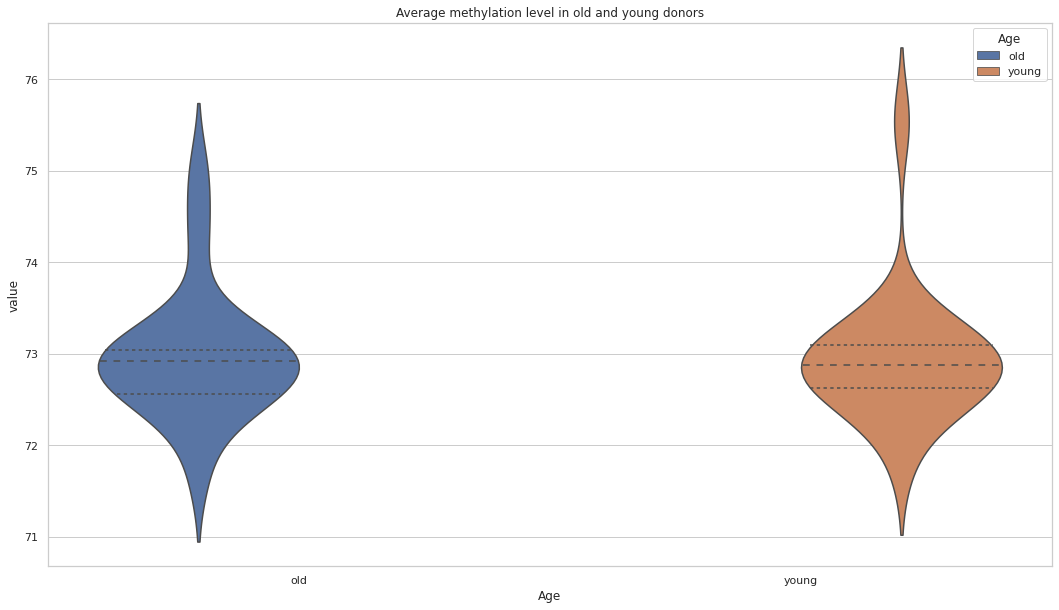

In [99]:
sns.set(rc={'figure.figsize':(18,10)}, style='whitegrid')
g = sns.violinplot(x="Age", y="value", hue="Age", data=old_young_melt, inner='quartile').set_title("Average methylation level in old and young donors")
g

### С более строгой отсечкой (пик хотя бы в половине файлов)

In [40]:
!mv ./sns_chip/sorted/intersected/filtered/merged/sloped_3000.bed ./concensus_methylation/

In [41]:
# среднее метилирование в пиках у старых доноров (без аутлаеров)
!bedtools map -a ./concensus_methylation/sloped_3000.bed -b ./concensus_methylation/filtered_cytosines_freq_sorted.bed -c 4,5,6,7,8,9,10,12,13,14,15,16,17,18,20,21,22,23 -o mean > ./concensus_methylation/old_mean_methyl_3000.bed

 ***** WARNING: Non numeric value NA in 20.
 ***** WARNING: Non numeric value NA in 23.
 ***** WARNING: Non numeric value NA in 23.
 ***** WARNING: Non numeric value NA in 23.
 ***** WARNING: Non numeric value NA in 23.
 ***** WARNING: Non numeric value NA in 22.
 ***** WARNING: Non numeric value NA in 23.
 ***** WARNING: Non numeric value NA in 18.
 ***** WARNING: Non numeric value NA in 23.
 ***** WARNING: Non numeric value NA in 7.
 ***** WARNING: Non numeric value NA in 20.
 ***** WARNING: Non numeric value NA in 22.
 ***** WARNING: Non numeric value NA in 5.
 ***** WARNING: Non numeric value NA in 15.
 ***** WARNING: Non numeric value NA in 18.
 ***** WARNING: Non numeric value NA in 21.
 ***** WARNING: Non numeric value NA in 5.
 ***** WARNING: Non numeric value NA in 23.
 ***** WARNING: Non numeric value NA in 14.
 ***** WARNING: Non numeric value NA in 20.
 ***** WARNING: Non numeric value NA in 15.
 ***** WARNING: Non numeric value NA in 23.
 ***** WARNING: Non numeric value N

In [42]:
# среднее метилирование в пиках у молодых доноров (без аутлаеров)
!bedtools map -a ./concensus_methylation/sloped_3000.bed -b ./concensus_methylation/filtered_cytosines_freq_sorted.bed -c 24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42 -o mean > ./concensus_methylation/young_mean_methyl_3000.bed

 ***** WARNING: Non numeric value NA in 39.
 ***** WARNING: Non numeric value NA in 42.
 ***** WARNING: Non numeric value NA in 42.
 ***** WARNING: Non numeric value NA in 42.
 ***** WARNING: Non numeric value NA in 42.
 ***** WARNING: Non numeric value NA in 37.
 ***** WARNING: Non numeric value NA in 42.
 ***** WARNING: Non numeric value NA in 40.
 ***** WARNING: Non numeric value NA in 42.
 ***** WARNING: Non numeric value NA in 32.
 ***** WARNING: Non numeric value NA in 33.
 ***** WARNING: Non numeric value NA in 42.
 ***** WARNING: Non numeric value NA in 29.
 ***** WARNING: Non numeric value NA in 38.
 ***** WARNING: Non numeric value NA in 40.
 ***** WARNING: Non numeric value NA in 29.
 ***** WARNING: Non numeric value NA in 39.
 ***** WARNING: Non numeric value NA in 31.
 ***** WARNING: Non numeric value NA in 42.
 ***** WARNING: Non numeric value NA in 37.
 ***** WARNING: Non numeric value NA in 42.
 ***** WARNING: Non numeric value NA in 30.
 ***** WARNING: Non numeric valu

In [57]:
# прочитываем старых
old = pd.read_table("./concensus_methylation/old_mean_methyl_3000.bed", sep="\t", header=None)

# оставляем только колонки с метилированием, координаты убираем, т.к. нас уже не интересуют конкретные пики
old_meth_only = old.iloc[:,3:]

# конвертируем значения метилирования во float, где точки - присваиваем NaN
old_meth_only = old_meth_only.apply(pd.to_numeric, errors='coerce') 

# считаем среднее по каждой колонке с донором (т.е. усредняем по всем пикам), присваиваем, что они old
old_mean = pd.DataFrame(old_meth_only.mean().to_dict(),index=[old_meth_only.index.values[-1]]).assign(Age='old')

# прочитываем молодых
young = pd.read_table("./concensus_methylation/young_mean_methyl_3000.bed", sep="\t", header=None)

# оставляем только колонки с метилированием, координаты убираем, т.к. нас уже не интересуют конкретные пики
young_meth_only = young.iloc[:,3:]

# конвертируем значения метилирования во float, где точки - присваиваем NaN
young_meth_only = young_meth_only.apply(pd.to_numeric, errors='coerce') 

# считаем среднее по каждой колонке с донором (т.е. усредняем по всем пикам), присваиваем, что они old
young_mean = pd.DataFrame(young_meth_only.mean().to_dict(),index=[young_meth_only.index.values[-1]]).assign(Age='young')

old_young = pd.concat([old_mean, young_mean])

# преобразуем DataFrame в формат, в котором столбец Age является идентификатором, и все измеренные значения 
# по каждому донору попадают в одну колонку value

old_young_melt = pd.melt(old_young, id_vars=['Age'])

old_young_melt.head()

,Age,variable,value
0,old,3,72.074311
1,young,3,72.076240
2,old,4,75.842816
3,young,4,73.504074
4,old,5,73.649725


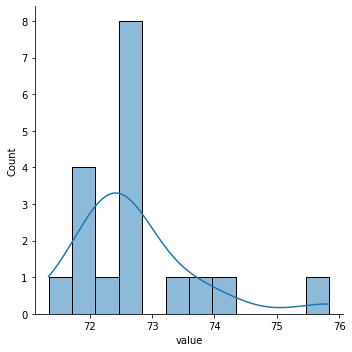

In [71]:
sns.displot(old_young_melt.query('Age == "old"').value, kde=True)

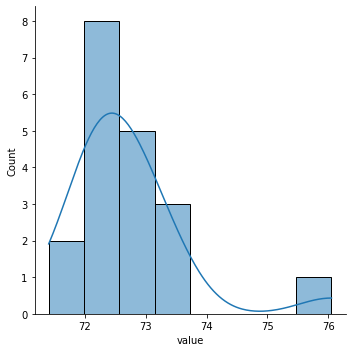

In [72]:
sns.displot(old_young_melt.query('Age == "young"').value, kde=True)

Text(0.5, 1.0, 'Average methylation level in old and young donors')

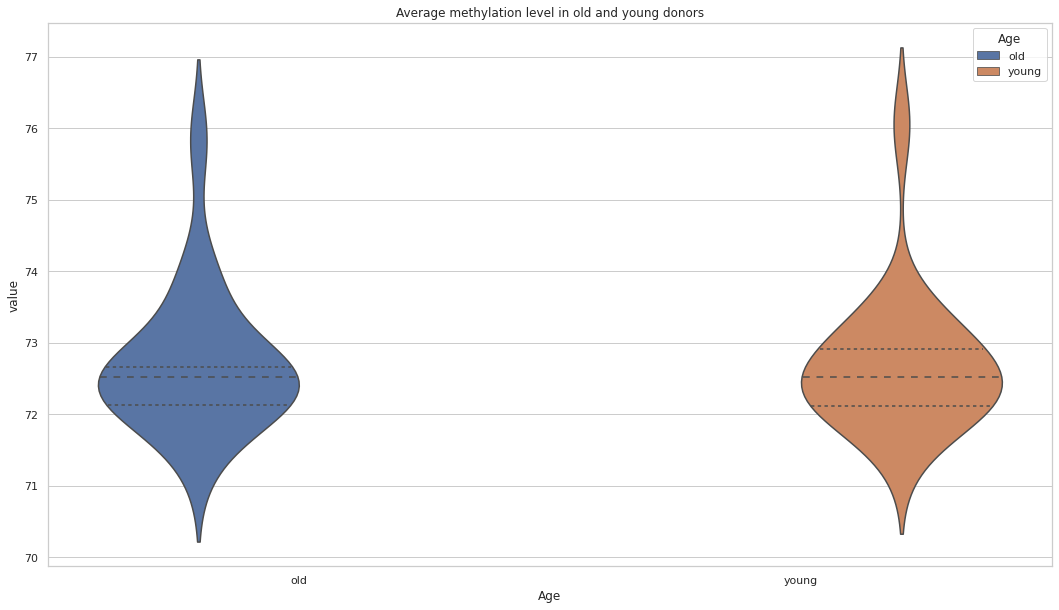

In [88]:
sns.set(rc={'figure.figsize':(18,10)}, style='whitegrid')
g = sns.violinplot(x="Age", y="value", hue="Age", data=old_young_melt, inner='quartile').set_title("Average methylation level in old and young donors")
g

## Поиск дифференциально метилированных регионов у молодых и старых

In [2]:
# прочитываем старых
old = pd.read_table("./concensus_methylation/old_mean_methyl_300.bed", sep="\t", header=None)
# прочитываем молодых
young = pd.read_table("./concensus_methylation/young_mean_methyl_300.bed", sep="\t", header=None)

In [3]:
old.iloc[:,1:] = old.iloc[:,1:].apply(pd.to_numeric, errors='coerce') 
young.iloc[:,1:] = young.iloc[:,1:].apply(pd.to_numeric, errors='coerce') 

In [4]:
old.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,chr1,15732,16499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,17100,17579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,51702,52638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,73127,73967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,136292,138375,70.50125,NaN,71.7525,70.946,74.479125,70.48375,68.58725,...,71.32675,70.384875,NaN,NaN,71.429875,66.909625,NaN,72.682875,69.921875,70.224375


In [5]:
young.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,chr1,15732,16499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,17100,17579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,51702,52638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,73127,73967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,136292,138375,72.73575,72.19725,71.093,64.58325,70.490625,71.206875,71.464875,...,71.590875,67.85725,69.974875,72.278,67.36975,72.855,72.6345,72.641,69.99475,72.42975


#### Информацию по координатам в геноме совместим в единую ячейку

In [6]:
old.insert(0, 'interval', old[old.columns[:3]].apply(lambda x: ':'.join(x.astype(str)), axis=1))

In [7]:
old.head()

,interval,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,chr1:15732:16499,chr1,15732,16499,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1:17100:17579,chr1,17100,17579,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1:51702:52638,chr1,51702,52638,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1:73127:73967,chr1,73127,73967,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1:136292:138375,chr1,136292,138375,70.50125,NaN,71.7525,70.946,74.479125,70.48375,...,71.32675,70.384875,NaN,NaN,71.429875,66.909625,NaN,72.682875,69.921875,70.224375


In [8]:
young.insert(0, 'interval', young[young.columns[:3]].apply(lambda x: ':'.join(x.astype(str)), axis=1))

In [9]:
young.head()

,interval,0,1,2,3,4,5,6,7,8,...,12,13,14,15,16,17,18,19,20,21
0,chr1:15732:16499,chr1,15732,16499,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1:17100:17579,chr1,17100,17579,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1:51702:52638,chr1,51702,52638,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1:73127:73967,chr1,73127,73967,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1:136292:138375,chr1,136292,138375,72.73575,72.19725,71.093,64.58325,70.490625,71.206875,...,71.590875,67.85725,69.974875,72.278,67.36975,72.855,72.6345,72.641,69.99475,72.42975


In [137]:
young.shape

(343858, 22)

#### Необходимо отфильтровать строки, где количество значений среднего метилирования не менее трех (условие для MW-test)

In [10]:
old_sub = old[old.iloc[:, 4:].notnull().sum(axis=1) >= 3] 

In [11]:
pd.set_option('display.max_columns', None)
old_sub.head()  # отфильтрованные старые

,interval,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
4,chr1:136292:138375,chr1,136292,138375,70.501250,NaN,71.752500,70.946000,74.479125,70.483750,68.587250,70.307875,71.326750,70.384875,NaN,NaN,71.429875,66.909625,NaN,72.682875,69.921875,70.224375
26,chr1:860561:861089,chr1,860561,861089,0.047844,NaN,2.253778,0.453111,0.178378,0.091644,0.076689,1.218422,0.177022,0.144556,0.6916,0.218267,0.143378,0.272267,0.256778,0.000000,0.091333,0.538644
28,chr1:863117:863783,chr1,863117,863783,82.916800,86.1824,85.789400,80.000200,91.777800,77.500200,96.000000,78.627600,83.000000,100.000000,94.2858,84.318800,79.914000,88.000000,90.000000,88.000000,80.000200,92.142800
29,chr1:863941:864053,chr1,863941,864053,99.359000,91.7445,98.780500,93.333250,94.875000,95.153750,97.826000,87.115500,94.058750,95.833250,88.8880,95.301250,90.805250,91.799500,89.464250,89.790500,91.594750,94.180250
30,chr1:866120:867405,chr1,866120,867405,87.391667,92.0790,84.977000,82.546333,76.555333,84.994333,77.745333,81.600000,84.909333,90.693333,85.3780,88.454667,91.200667,86.237333,81.095000,84.807000,83.622000,84.627667


In [12]:
young_sub = young[young.iloc[:, 3:].notnull().sum(axis=1) >= 3] 

In [13]:
young_sub.head()  # отфильтрованные молодые

,interval,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
4,chr1:136292:138375,chr1,136292,138375,72.735750,72.197250,71.093000,64.583250,70.490625,71.206875,71.464875,NaN,69.858000,71.590875,67.857250,69.974875,72.278000,67.369750,72.855000,72.634500,72.641000,69.994750,72.429750
26,chr1:860561:861089,chr1,860561,861089,0.259978,0.109244,0.128800,0.447244,0.468489,0.166467,0.150667,0.071267,0.114711,0.191200,0.133756,0.153000,0.210000,0.556489,0.575022,0.111756,0.040644,0.173378,0.492733
28,chr1:863117:863783,chr1,863117,863783,81.538400,NaN,89.230800,90.865800,87.904800,92.800000,85.833400,91.428600,100.000000,95.494600,90.666800,98.181800,87.142800,85.714200,94.285600,96.666600,80.000000,92.000000,93.750000
29,chr1:863941:864053,chr1,863941,864053,92.163750,95.454500,95.225750,95.089250,90.791250,88.467250,94.834750,93.429000,98.750000,93.193250,95.388000,87.987750,94.407500,92.296000,93.115500,95.654000,85.288750,85.429750,90.419000
30,chr1:866120:867405,chr1,866120,867405,88.545667,93.123667,82.761667,91.699000,85.115333,94.094000,90.048000,81.633667,81.990667,87.777667,88.959000,74.615333,82.316333,87.063333,82.428333,84.609000,82.137667,90.061667,84.143333


In [14]:
old_sub.shape[0]

48274

In [15]:
young_sub.shape[0]

48318

In [16]:
common = old_sub.merge(young_sub, on=["interval"])  # inner join по колонке interval
common.shape[0]  # совпадающих интервалов

48259

In [17]:
young_res = young_sub[young_sub["interval"].isin(common["interval"])]  # из молодых оставляем только те, которые попали в inner join
old_res = old_sub[old_sub["interval"].isin(common["interval"])]  # из старых оставляем только те, которые попали в inner join

In [ ]:
# теперь среди этих пиков можно искать дифференциально метилированные регионы, считать критерий Манна-Уитни

## Манна-Уитни

In [48]:
young_res.head()

,interval,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
4,chr1:136292:138375,chr1,136292,138375,72.735750,72.197250,71.093000,64.583250,70.490625,71.206875,71.464875,NaN,69.858000,71.590875,67.857250,69.974875,72.278000,67.369750,72.855000,72.634500,72.641000,69.994750,72.429750
26,chr1:860561:861089,chr1,860561,861089,0.259978,0.109244,0.128800,0.447244,0.468489,0.166467,0.150667,0.071267,0.114711,0.191200,0.133756,0.153000,0.210000,0.556489,0.575022,0.111756,0.040644,0.173378,0.492733
28,chr1:863117:863783,chr1,863117,863783,81.538400,NaN,89.230800,90.865800,87.904800,92.800000,85.833400,91.428600,100.000000,95.494600,90.666800,98.181800,87.142800,85.714200,94.285600,96.666600,80.000000,92.000000,93.750000
29,chr1:863941:864053,chr1,863941,864053,92.163750,95.454500,95.225750,95.089250,90.791250,88.467250,94.834750,93.429000,98.750000,93.193250,95.388000,87.987750,94.407500,92.296000,93.115500,95.654000,85.288750,85.429750,90.419000
30,chr1:866120:867405,chr1,866120,867405,88.545667,93.123667,82.761667,91.699000,85.115333,94.094000,90.048000,81.633667,81.990667,87.777667,88.959000,74.615333,82.316333,87.063333,82.428333,84.609000,82.137667,90.061667,84.143333


In [49]:
old_res.head()

,interval,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
4,chr1:136292:138375,chr1,136292,138375,70.501250,NaN,71.752500,70.946000,74.479125,70.483750,68.587250,70.307875,71.326750,70.384875,NaN,NaN,71.429875,66.909625,NaN,72.682875,69.921875,70.224375
26,chr1:860561:861089,chr1,860561,861089,0.047844,NaN,2.253778,0.453111,0.178378,0.091644,0.076689,1.218422,0.177022,0.144556,0.6916,0.218267,0.143378,0.272267,0.256778,0.000000,0.091333,0.538644
28,chr1:863117:863783,chr1,863117,863783,82.916800,86.1824,85.789400,80.000200,91.777800,77.500200,96.000000,78.627600,83.000000,100.000000,94.2858,84.318800,79.914000,88.000000,90.000000,88.000000,80.000200,92.142800
29,chr1:863941:864053,chr1,863941,864053,99.359000,91.7445,98.780500,93.333250,94.875000,95.153750,97.826000,87.115500,94.058750,95.833250,88.8880,95.301250,90.805250,91.799500,89.464250,89.790500,91.594750,94.180250
30,chr1:866120:867405,chr1,866120,867405,87.391667,92.0790,84.977000,82.546333,76.555333,84.994333,77.745333,81.600000,84.909333,90.693333,85.3780,88.454667,91.200667,86.237333,81.095000,84.807000,83.622000,84.627667


In [18]:
meth_regions_mw = pd.DataFrame(columns=["interval", "stat", "p_val"])
meth_regions_mw

,interval,stat,p_val


In [19]:
for i in range(len(old_res)):
    stat, p = mannwhitneyu(old_res.iloc[i,3:], young_res.iloc[i,3:])
    meth_regions_mw = meth_regions_mw.append({'interval': old_res.iloc[i,0], 'stat': stat, 'p_val': p}, ignore_index=True)

In [20]:
meth_regions_mw.head()

,interval,stat,p_val
0,chr1:136292:138375,181.0,0.405619
1,chr1:860561:861089,170.0,0.291879
2,chr1:863117:863783,119.5,0.024584
3,chr1:863941:864053,174.5,0.336701
4,chr1:866120:867405,173.5,0.326505


In [ ]:
####### Поправка на множественные сравнения!! 

#### Оставляем только те, у которых отличия значимые

In [21]:
diff_methylated = meth_regions_mw[meth_regions_mw["p_val"] < 0.05]

In [22]:
diff_methylated

,interval,stat,p_val
2,chr1:863117:863783,119.5,0.024584
6,chr1:876359:878041,108.0,0.011012
20,chr1:915496:918319,122.0,0.028941
25,chr1:931045:934172,129.0,0.044575
27,chr1:936320:937419,118.0,0.022270
...,...,...,...
48215,chrX:153405441:153406377,130.5,0.031491
48218,chrX:153512983:153514923,120.0,0.025417
48219,chrX:153532262:153537741,106.5,0.009845
48221,chrX:153559574:153562141,87.5,0.002078


#### Визуализация

In [23]:
common = old.merge(diff_methylated, on=["interval"])  # inner join by interval column

In [24]:
# из таблицы метилирования у молодых и у старых (со всеми регионами, куда оно попало) 
# выбираем только значимо дифференциально метилированные регионы
young_diff_meth_regions = young[young["interval"].isin(common["interval"])]  
old_diff_meth_regions = old[old["interval"].isin(common["interval"])] 

In [108]:
young_diff_meth_regions.shape

(5065, 23)

In [25]:
# считаем среднее по всем донорам в каждом регионе, записываем в новый df с указанием Age
old_avg_meth = pd.DataFrame({'interval': old_diff_meth_regions["interval"], 'mean_meth': old_diff_meth_regions.iloc[:,4:].mean(axis=1)}).assign(Age='old')

In [26]:
old_avg_meth.head()

,interval,mean_meth,Age
28,chr1:863117:863783,86.580889,old
33,chr1:876359:878041,0.638010,old
50,chr1:915496:918319,79.966504,old
55,chr1:931045:934172,15.200251,old
57,chr1:936320:937419,1.745939,old


In [27]:
# считаем среднее по всем донорам в каждом регионе, записываем в новый df с указанием Age
young_avg_meth = pd.DataFrame({'interval': young_diff_meth_regions["interval"], 'mean_meth': young_diff_meth_regions.iloc[:,4:].mean(axis=1)}).assign(Age='young')

In [62]:
young_avg_meth.head()

,interval,mean_meth,Age
28,chr1:863117:863783,90.750233,young
33,chr1:876359:878041,0.533179,young
50,chr1:915496:918319,81.481385,young
55,chr1:931045:934172,14.295245,young
57,chr1:936320:937419,1.409862,young


In [ ]:
# конкатенируем

In [97]:
old_young = pd.concat([old_avg_meth, young_avg_meth])

In [98]:
old_young.head()

,interval,mean_meth,Age
28,chr1:863117:863783,86.580889,old
33,chr1:876359:878041,0.638010,old
50,chr1:915496:918319,79.966504,old
55,chr1:931045:934172,15.200251,old
57,chr1:936320:937419,1.745939,old


<AxesSubplot:xlabel='Age', ylabel='mean_meth'>

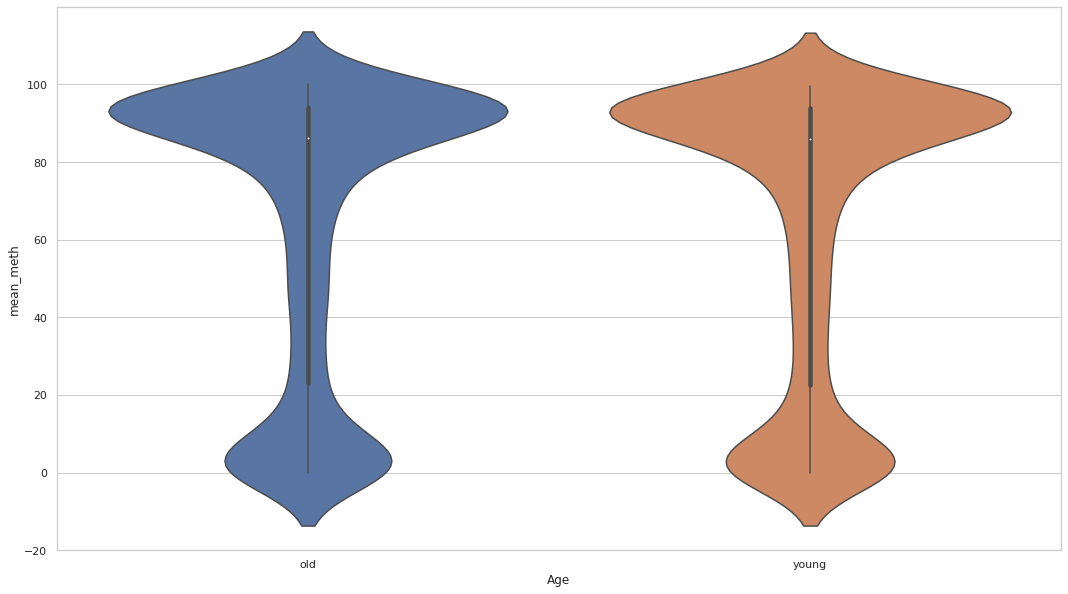

In [110]:
sns.violinplot(data=old_young, x='Age', y='mean_meth')

In [32]:
diff_meth_by_interval = old_young.pivot(index=['interval'], columns='Age', values='mean_meth').reset_index()

In [93]:
diff_meth_by_interval.head(10)

Age,interval,old,young
0,chr10:101710156:101711106,96.292667,99.001842
1,chr10:102501292:102502570,4.399541,4.077808
2,chr10:102854018:102854945,77.218833,82.154895
3,chr10:103369404:103369940,94.311278,95.843158
4,chr10:103576683:103577638,0.076800,0.000000
5,chr10:103601946:103603442,25.521902,24.018116
6,chr10:103848392:103849316,97.258056,95.817825
7,chr10:103869549:103869911,96.501368,95.232559
8,chr10:103967362:103968608,96.214319,94.528158
9,chr10:112838941:112840761,81.584755,77.165579


In [34]:
diff_meth_by_interval.shape[0] #  значимо метилированные регионы у молодых и старых

5065

Как визуализируем? 